In [ ]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
# from tensorflow import keras

# from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
# import tensorflow as tf
#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

# Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

In [ ]:
# Hyperparameters
batch_size = 32
num_classes = 10
epochs = 10
l = 12
num_filter = 18
compression = 1
dropout_rate = 0.2

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
#from IPython.display import IFrame, YouTubeVideo
#YouTubeVideo(id='-W6y8xnd--U', width=600)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_104 (Conv2D)            (None, 32, 32, 12)   324         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_104 (Batch  (None, 32, 32, 12)  48          ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_104 (Activation)    (None, 32, 32, 12)   0           ['batch_normalization_104[0

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Epoch 1/10
391/391 [==============================] - 44s 98ms/step - loss: 1.7483 - accuracy: 0.3372 - val_loss: 1.7087 - val_accuracy: 0.3877
Epoch 2/10
391/391 [==============================] - 38s 96ms/step - loss: 1.4112 - accuracy: 0.4740 - val_loss: 1.3184 - val_accuracy: 0.5187
Epoch 3/10
391/391 [==============================] - 37s 96ms/step - loss: 1.2275 - accuracy: 0.5472 - val_loss: 1.4623 - val_accuracy: 0.5004
Epoch 4/10
391/391 [==============================] - 38s 97ms/step - loss: 1.1132 - accuracy: 0.5933 - val_loss: 1.2776 - val_accuracy: 0.5436
Epoch 5/10
391/391 [==============================] - 38s 97ms/step - loss: 1.0374 - accuracy: 0.6227 - val_loss: 1.0683 - val_accuracy: 0.6183
Epoch 6/10
391/391 [==============================] - 38s 96ms/step - loss: 0.9783 - accuracy: 0.6466 - val_loss: 1.4106 - val_accuracy: 0.5612
Epoch 7/10
391/391 [==============================] - 38s 97ms/step - loss: 0.9322 - accuracy: 0.6653 - val_loss: 1.5930 - val_accuracy:

In [ ]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 10ms/step - loss: 1.1835 - accuracy: 0.6295
Test loss: 1.1834781169891357
Test accuracy: 0.6294999718666077


In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
del model

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use DropOut layers.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
def normalization(train, test):
  
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  train_norm = train_norm / 255
  test_norm = test_norm / 255

  return (train_norm, test_norm)

In [ ]:
X_train, X_test = normalization(X_train, X_test)

In [ ]:
image1 = X_train[4]
image1.shape

(32, 32, 3)

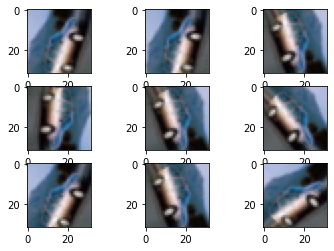

In [ ]:
images1 = expand_dims(image1, 0)

datagen = ImageDataGenerator(rotation_range=90)
iterator1 = datagen.flow(images1, batch_size=1)
for i in range(9):
  plt.subplot(330+1+i)
  batch = iterator1.next()
  image = batch[0]
  plt.imshow(image)

plt.show()

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
batch_size = 32
l = 12
num_filter = 18
compression = 1

traindataGen=ImageDataGenerator(shear_range=0.2, zoom_range=0.2, height_shift_range=0.1, horizontal_flip=True) 
#---Try with different augmentation techniques.
# Donot apply any augmentation on test data
testdataGen=ImageDataGenerator()

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs = [input], outputs = [output])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_156 (Conv2D)            (None, 32, 32, 18)   486         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_156 (Batch  (None, 32, 32, 18)  72          ['conv2d_156[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_156 (Activation)    (None, 32, 32, 18)   0           ['batch_normalization_156[0

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

NameError: ignored

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/CNNonCIFR/weights1.hdf5')

In [ ]:
process_staging(X_train, y_train, X_test, y_test, 32, 40, 10)

## Summary

Best Accuracy achieved so far is 58.64